# Proyecto IC - Segunda parte: Estimación de efectos causales mediante DoubleML y Meta-learners

### Autores: Nicolás Camañes, Pedro José Cánovas, Javier Hinarejos Albero, Diego Lacomba Fañanas y Isaac Martí García

Tras haber realizado la selección de variables y el emparejamiento con el objetivo de obtener una estimación no sesgada del efecto causal en la parte anterior, haremos uso de metalearnes como alternativa a la estimación del efeto causal.
También intentaremos obtener una medida más detallada del efecto del tratamiento al estudiar su efecto por grupos, permitiendo aislar segmentos de la población sobre los que priorizar el tratamiento.

Cargamos los datos obtenidos en la parte anterior.

In [7]:
import pandas as pd
data_total = pd.read_csv("data/data.csv")
data_total.head()
print(data_total.shape)

(461148, 18)


In [8]:
# Calcular las medias de las covariables por grupo de tratamiento
group_means = data_total.groupby('refinancing').mean().T

# Mostrar los resultados
print(group_means)

refinancing                         0              1
Unnamed: 0              233775.978917  229999.974989
agency_code                  7.231889       7.211849
loan_type                    1.504050       1.570348
property_type                1.082216       1.035802
owner_occupancy              1.110514       1.100039
loan_amount_000s           193.664523     180.293153
applicant_ethnicity          2.268364       2.219575
co_applicant_ethnicity       3.857711       3.867230
applicant_race_1             4.927736       4.878081
co_applicant_race_1          6.755301       6.769939
applicant_sex                1.723536       1.631411
co_applicant_sex             3.772387       3.793366
purchaser_type               1.845197       1.052673
denied                       0.120887       0.181781
distance                     0.337363       0.389468
weights                      1.000000       1.000000
subclass                 37040.177842   39971.421828


## Modelos ML

En este análisis, emplearemos la metodología de Double Machine Learning (DoubleML) para estimar el efecto causal del propósito del préstamo (loan_purpose = "Refinancing") en la probabilidad de que una solicitud de hipoteca sea denegada (action_taken). Antes de aplicar DoubleML, hemos preprocesado los datos utilizando la herramienta MatchIt para realizar emparejamientos, equilibrando así los grupos de tratamiento y control en términos de sus covariables y reduciendo el sesgo de selección. Aunque el matching no es un requisito para utilizar DoubleML, hemos decidido aprovecharlo ya que lo calculamos en pasos previos.

Hemos creado una variable binaria de tratamiento, "refinancing", que indica si el propósito del préstamo es igual a 3, y una variable de resultado, "denied", que indica si la hipoteca ha sido denegada. Implementaremos dos modelos de DoubleML, utilizando Random Forest y XGBoost, para estimar este efecto. Estas técnicas avanzadas de aprendizaje supervisado nos permiten controlar por posibles variables de confusión y obtener estimaciones robustas.

El objetivo es comparar los coeficientes estimados y sus intervalos de confianza para evaluar la consistencia y significancia del efecto del tratamiento sobre el resultado.

Debido al gran número de instancias, vamos a trabajar con una porción de los datos que nos permita obtener buenos resultados con un coste computacional y temporal asequible. El modelo doubleML no exige que la muestra esté balanceada ya que emplea una especificación paramétrica para estimar el efecto causal.

In [9]:
data = data_total.sample(frac=0.05, random_state=1)

data.shape

(23057, 18)

Definimos los modelos que ajustarán las funciones nuisance del modelo double ML.

In [10]:
from doubleml import DoubleMLData
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from doubleml import DoubleMLPLR
import pandas as pd

# Variables independientes (covariates)
X = data

# Modelos base para el aprendizaje supervisado
ml_m_rf = RandomForestRegressor()  # Modelo de Random Forest para la media condicional de la respuesta
ml_e_rf = RandomForestClassifier() # Modelo de Random Forest para el propensity score 

ml_m_xgb = XGBRegressor(objective = "reg:squarederror")  # Modelo de XGBoost para la media condicional de la respuesta
ml_e_xgb = XGBClassifier(use_label_encoder = False,       # Modelo de XGBoost para el propensity score
                         objective = "binary:logistic",
                         eval_metric = "logloss")

### Especificación DML

Inicialmente probamos con dos modelos, el primero empleando Random Forest tanto para la regresión como para la clasificación y el segundo empleando XGBoost.

In [11]:
# Configurar DoubleML con los datos
dml_data = DoubleMLData(X, "denied", "refinancing")

# Configuración del modelo DoubleMLPLR con Random Forest
dml_plr_forest = DoubleMLPLR(dml_data,
                             ml_l = ml_m_rf, # Modelo ML para la media condicional de la respuesta
                             ml_m = ml_e_rf, # Modelo ML para el propensity score
                             n_folds = 10)   # Número de pliegues para la validación cruzada

# Configuración del modelo DoubleMLPLR con XGBoost
dml_plr_xgb = DoubleMLPLR(dml_data,
                             ml_l = ml_m_xgb, # Modelo ML para la media condicional de la respuesta
                             ml_m = ml_e_xgb, # Modelo ML para el propensity score
                             n_folds = 10)    # Número de pliegues para la validación cruzada


### Estimación e inferencia

Entrenamiento

In [12]:
# Ajustar el modelo con Random Forest
dml_plr_forest.fit()

# Ajustar el modelo con XGBoost
dml_plr_xgb.fit()

c:\Users\Victor\anaconda3\Lib\site-packages\doubleml\_utils_checks.py:204: UserWarning: Propensity predictions from learner RandomForestClassifier() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Observamos la pérdida de los modelos para las dos funciones nuisance

In [13]:
print(dml_plr_forest.evaluate_learners())
print(dml_plr_xgb.evaluate_learners())

{'ml_l': array([[0.30088414]]), 'ml_m': array([[0.03172554]])}
{'ml_l': array([[0.30332889]]), 'ml_m': array([[0.03254593]])}


Los resultados de las evaluaciones indican que ambos modelos, Random Forest y XGBoost, tienen un desempeño similar en regresión (ml_l), con valores muy cercanos (0.3008 vs. 0.3033). Sin embargo, en clasificación (ml_m), el Random Forest se desempeña mejor (0.0317 vs. 0.0325).

Por lo tanto, se propone utilizar Random Forest para la regresión y la clasificación.

#### Inferencia

In [14]:
# Crear un resumen de los coeficientes y los intervalos de confianza
plr_summary = pd.concat((dml_plr_xgb.summary,   # Resumen del modelo XGBoost
                         dml_plr_forest.summary)) # Resumen del modelo Random Forest)
plr_summary.index = ['xgb', 'Forest']
plr_summary[['coef', '2.5 %', '97.5 %', 'P>|t|']]  # Seleccionar los coeficientes y los intervalos de confianza

,coef,2.5 %,97.5 %,P>|t|
xgb,-0.001958,-0.144384,0.140467,0.978500
Forest,0.174709,0.051198,0.298220,0.005564


El modelo Random Forest proporciona la estimación más consistente y significativa del efecto del predictor sobre la variable de interés, con un coeficiente de 0.1747 y un intervalo de confianza que no incluye el cero. Por otro lado, el modelo XGBoost muestra coeficientes no significativos, lo que sugiere que sus estimaciones del efecto del predictor no son concluyentes al nivel de confianza del 95%. Por lo tanto, para este conjunto de datos y el predictor en cuestión, el modelo Random Forest parece ser la mejor opción.

### Sensibilidad

In [15]:
dml_plr_forest.sensitivity_analysis()
print(dml_plr_forest.sensitivity_summary)

================== Sensitivity Analysis ==================

------------------ Scenario          ------------------
Significance Level: level=0.95
Sensitivity parameters: cf_y=0.03; cf_d=0.03, rho=1.0

------------------ Bounds with CI    ------------------
             CI lower  theta lower     theta  theta upper  CI upper
refinancing -0.218639    -0.114127  0.174709     0.463546  0.567018

------------------ Robustness Values ------------------
             H_0    RV (%)   RVa (%)
refinancing  0.0  1.825677  0.744887


Los resultados del análisis de sensibilidad con una variabilidad del 3% en las variables de resultado (cf_y=0.03) y de tratamiento (cf_d=0.03) con el modelo DML Random Forest (dml_plr_forest) muestran que la estimación del efecto causal para la variable refinancing varía considerablemente, con intervalos de confianza que van desde -0.2186 hasta 0.5670, sugiriendo tanto efectos negativos como positivos.

Los valores de robustez (RV=1.83%, RVa=0.74%) revelan que el modelo puede tolerar pequeñas desviaciones en las variables de sensibilidad antes de que los resultados dejen de ser significativos, indicando una relativa estabilidad en las estimaciones del efecto causal a pesar de las posibles variaciones en las condiciones del modelo.

### GATEs

#### Agrupamos por Ethinicity

A continuación, estudiaremos el efecto causal del propósito del préstamo en la probabilidad de denegación de hipotecas, dividiendo a los solicitantes en grupos según su etnia. Este enfoque nos permitirá identificar si existen diferencias significativas entre los distintos grupos étnicos.

In [16]:
import numpy as np
grupos_Ethnicity = pd.DataFrame(
    np.column_stack((data['applicant_race_1'] == 1,
                     data['applicant_race_1'] == 2,
                     data['applicant_race_1'] == 3,
                     data['applicant_race_1'] == 4,
                     data['applicant_race_1'] == 5)),
    columns=['American Indian', 'Asian', 'Black', 'Pacific Islander', 'White'])
print(grupos_Ethnicity.head())

# Contar el número de muestras por grupo
grupos_Ethnicity.sum()

   American Indian  Asian  Black  Pacific Islander  White
0            False  False  False             False   True
1            False  False  False             False  False
2            False  False   True             False  False
3            False  False  False             False   True
4            False  False  False             False   True


American Indian       194
Asian                 680
Black                2866
Pacific Islander       50
White               14645
dtype: int64

In [17]:
# Crear un DataFrame solo con los grupos "Black" y "White"
grupos_BW = grupos_Ethnicity[['Black', 'White']]
grupos_BW.sum()

Black     2866
White    14645
dtype: int64

In [18]:
gate_bw = dml_plr_forest.gate(groups = grupos_BW)
gate_bw.confint(level = 0.95)

,2.5 %,effect,97.5 %
Black,-0.196928,0.274527,0.745981
White,0.011458,0.195785,0.380113


El nuevo DataFrame grupos_BW se crea seleccionando solo las columnas 'Black' y 'White' del DataFrame original grupos_Ethnicity. Esto se debe a que el número de muestras en los otros grupos ("American Indian", "Asian", "Pacific Islander") es muy bajo, lo que puede no ser suficiente para un análisis estadístico robusto.

Este ajuste permite enfocar el análisis en los grupos con un tamaño de muestra más significativo, mejorando la precisión y la confiabilidad de los resultados.

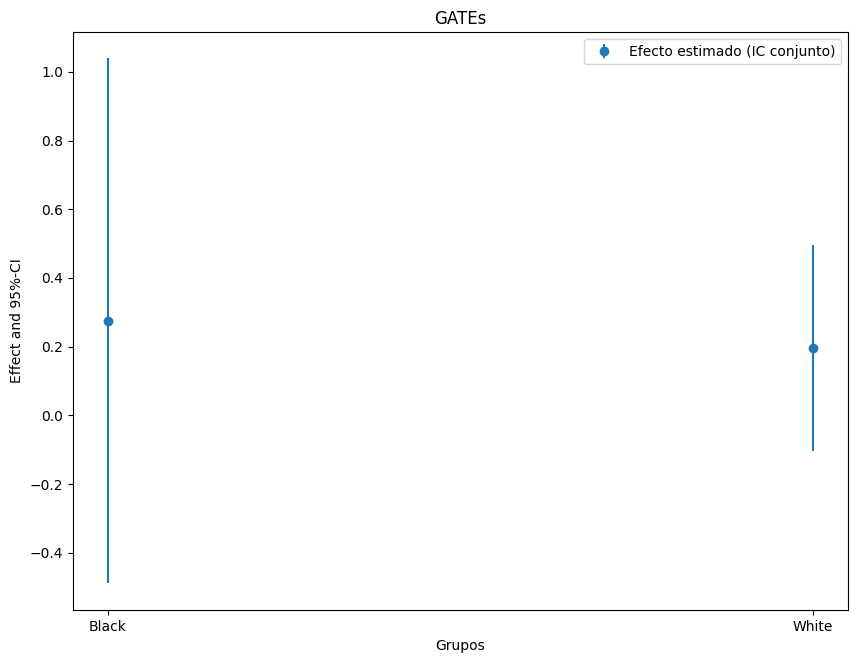

In [19]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5
ci = gate_bw.confint(level=0.95, joint=True)

errors = np.full((2, ci.shape[0]), np.nan)
errors[0, :] = ci['effect'] - ci['2.5 %']
errors[1, :] = ci['97.5 %'] - ci['effect']

plt.errorbar(ci.index, ci.effect, fmt='o', yerr=errors, label='Efecto estimado (IC conjunto)')

plt.title('GATEs')
plt.xlabel('Grupos')
plt.legend()
_ = plt.ylabel('Effect and 95%-CI')

In [20]:
gate_bw.summary

,coef,std err,t,P>|t|,[0.025,0.975]
Black,0.274527,0.196703,1.395642,0.162836,-0.111024,0.660077
White,0.195785,0.087982,2.225299,0.026071,0.023336,0.368235


Para el grupo "Black", el coeficiente de 0.2745 sugiere un efecto positivo marginalmente significativo del propósito del préstamo en la probabilidad de denegación de la hipoteca. Sin embargo, debido a que el intervalo de confianza incluye el cero y el valor p es justo en el umbral de significancia, este resultado debe interpretarse con cautela.

Para el grupo "White", el coeficiente de 0.1958 no es significativo, como lo indica el alto valor p y el intervalo de confianza que incluye el cero. Esto sugiere que no hay un efecto significativo del propósito del préstamo en la probabilidad de denegación de la hipoteca para este grupo.

#### Agrupamos por Sex

Una vez analizado el efecto del propósito del préstamo en la probabilidad de denegación de hipotecas según la etnia del solicitante, procederemos a estudiar cómo el sexo del solicitante influye en esta misma probabilidad. Este análisis adicional nos permitirá identificar si existen diferencias significativas en la denegación de hipotecas basadas en el sexo del solicitante.

In [21]:
grupos_Sex = pd.DataFrame(
    np.column_stack((data['applicant_sex'] == 1,
                     data['applicant_sex'] == 2)),
    columns=['Male', 'Female'])
print(grupos_Sex.head())

# Contar el número de muestras por grupo
grupos_Sex.sum()

    Male  Female
0   True   False
1  False   False
2  False    True
3   True   False
4  False    True


Male      12872
Female     6447
dtype: int64

In [22]:
gate_sex = dml_plr_forest.gate(groups = grupos_Sex)
gate_sex.confint(level = 0.95)

,2.5 %,effect,97.5 %
Male,-0.006648,0.188609,0.383866
Female,0.009908,0.291049,0.572189


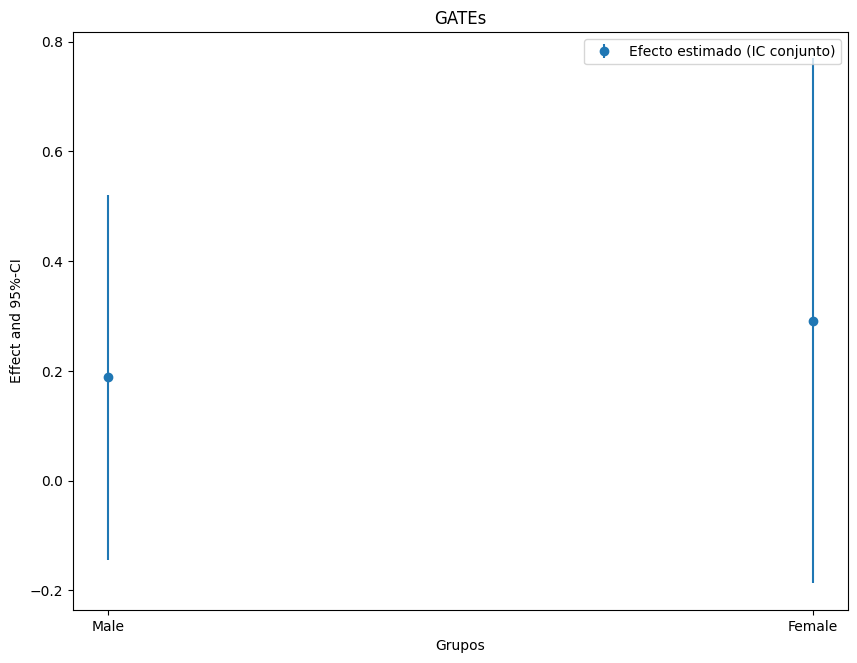

In [23]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5
ci = gate_sex.confint(level=0.95, joint=True)

errors = np.full((2, ci.shape[0]), np.nan)
errors[0, :] = ci['effect'] - ci['2.5 %']
errors[1, :] = ci['97.5 %'] - ci['effect']

plt.errorbar(ci.index, ci.effect, fmt='o', yerr=errors, label='Efecto estimado (IC conjunto)')

plt.title('GATEs')
plt.xlabel('Grupos')
plt.legend()
_ = plt.ylabel('Effect and 95%-CI')

In [24]:
gate_sex.summary

,coef,std err,t,P>|t|,[0.025,0.975]
Male,0.188609,0.090425,2.085805,0.037007,0.011370,0.365848
Female,0.291049,0.131750,2.209104,0.027177,0.032811,0.549287


Los resultados indican que no hay evidencia significativa de que el propósito del préstamo por refinanciamiento afecte la probabilidad de denegación de la hipoteca de manera diferente para hombres y mujeres. Los coeficientes para ambos grupos no son estadísticamente significativos, y los intervalos de confianza incluyen el cero, sugiriendo que no se puede afirmar con certeza que el refinanciamiento tiene un efecto en la probabilidad de denegación de hipotecas basado en el sexo del solicitante.

#### Agrupamos por Tipo de propiedad

In [25]:
grupos_property_type = pd.DataFrame(
    np.column_stack((data['property_type'] == 1,
                     data['property_type'] == 2,
                     data['property_type'] == 3)),
    columns=['One to four-family', 'Manufactured housing', 'Multifamily'])
print(grupos_property_type.head())

# Contar el número de muestras por grupo
grupos_property_type.sum()

   One to four-family  Manufactured housing  Multifamily
0                True                 False        False
1               False                  True        False
2                True                 False        False
3                True                 False        False
4               False                  True        False


One to four-family      21590
Manufactured housing     1444
Multifamily                23
dtype: int64

Hay muy pocas instancias del tipo 3. Nos quedamos con los tipos 1 y 2.

In [26]:
grupos_property_type = pd.DataFrame(
    np.column_stack((data['property_type'] == 1,
                     data['property_type'] == 2)),
    columns=['One to four-family', 'Manufactured housing'])
print(grupos_property_type.head())

# Contar el número de muestras por grupo
grupos_property_type.sum()

   One to four-family  Manufactured housing
0                True                 False
1               False                  True
2                True                 False
3                True                 False
4               False                  True


One to four-family      21590
Manufactured housing     1444
dtype: int64

In [27]:
gate_property_type = dml_plr_forest.gate(groups = grupos_property_type)
gate_property_type.confint(level = 0.95)

,2.5 %,effect,97.5 %
One to four-family,0.067455,0.189143,0.310830
Manufactured housing,-0.542881,0.026328,0.595538


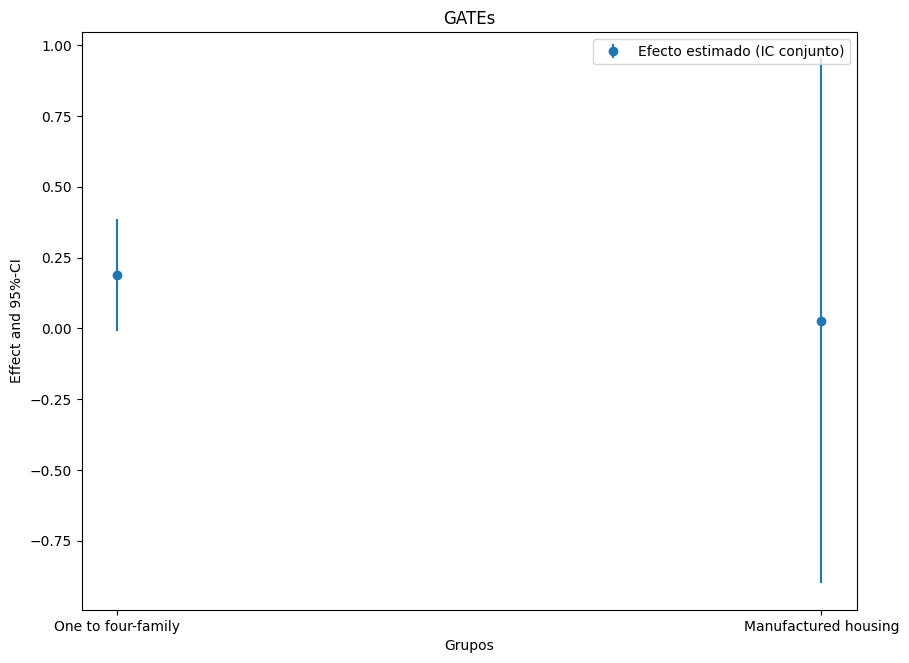

In [28]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5
ci = gate_property_type.confint(level=0.95, joint=True)

errors = np.full((2, ci.shape[0]), np.nan)
errors[0, :] = ci['effect'] - ci['2.5 %']
errors[1, :] = ci['97.5 %'] - ci['effect']

plt.errorbar(ci.index, ci.effect, fmt='o', yerr=errors, label='Efecto estimado (IC conjunto)')

plt.title('GATEs')
plt.xlabel('Grupos')
plt.legend()
_ = plt.ylabel('Effect and 95%-CI')

In [29]:
gate_property_type.summary

,coef,std err,t,P>|t|,[0.025,0.975]
One to four-family,0.189143,0.065967,2.867251,0.004144,0.059844,0.318441
Manufactured housing,0.026328,0.198461,0.132663,0.894461,-0.362668,0.415325


Para el grupo "One to four-family", el coeficiente de 0.1891 sugiere un efecto positivo marginalmente significativo del propósito del préstamo en la probabilidad de denegación de la hipoteca.
Para el grupo "Manufactured housing", el coeficiente de 0.0263 no es significativo, como lo indica el alto valor p y el intervalo de confianza que incluye el cero. Esto sugiere que no hay un efecto significativo del propósito del préstamo en la probabilidad de denegación de la hipoteca para este grupo.

## Metalerners

Los metalerners, como los T-learners, S-learners y X-learners, ofrecen una alternativa flexible y robusta al Double Machine Learning (DoubleML) en el análisis del efecto causal. Mientras que DoubleML se enfoca en corregir el sesgo a través de un proceso en dos etapas y proporciona estimaciones asintóticamente eficientes, los metalerners combinan múltiples modelos base para mejorar la precisión y reducir la varianza de las estimaciones. Esta capacidad de integrar diferentes modelos permite a los metalerners adaptarse mejor a diversos tipos de datos y contextos, proporcionando una mayor flexibilidad y robustez en la estimación del efecto causal.

In [30]:
# importamos metalearners
from econml.metalearners import TLearner, SLearner, XLearner
from econml.dr import DRLearner

#  importamos librerias auxiliares
import numpy as np
from numpy.random import binomial, multivariate_normal, normal, uniform
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [31]:
X_covariates = data.drop(columns=['denied', 'refinancing'])
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X_covariates, data["refinancing"], data["denied"], test_size=0.2, random_state=42)

### T learner

(array([   6.,   24.,   57.,  101.,  323., 2196., 1160.,  587.,  143.,
          15.]),
 array([-0.49388961, -0.40703689, -0.32018418, -0.23333146, -0.14647875,
        -0.05962603,  0.02722668,  0.1140794 ,  0.20093211,  0.28778483,
         0.37463754]),
 <BarContainer object of 10 artists>)

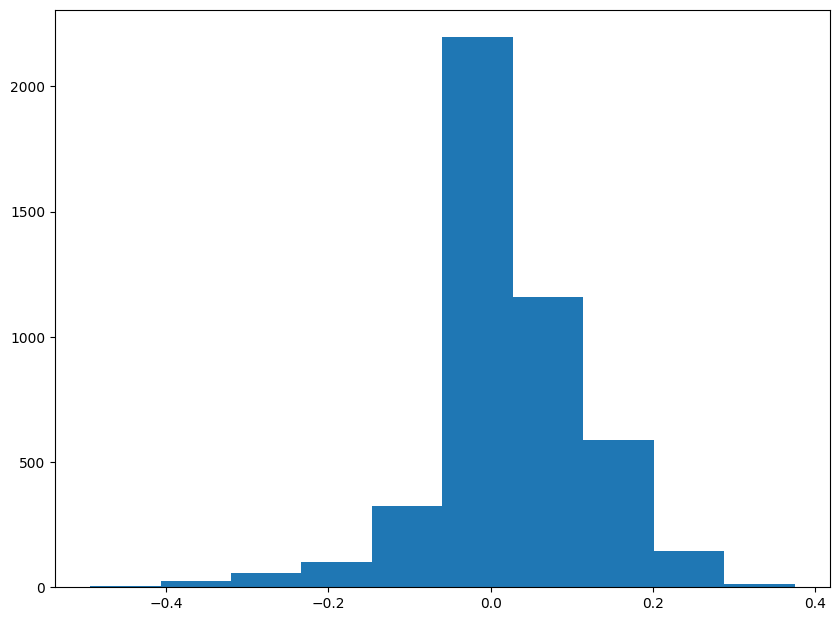

In [32]:
# Creamos una instancia del T learner
n = data.shape[0]
models = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
T_learner = TLearner(models=models)

# Entrenamiento del T_learner (con la opción inference para poder realizar inferencia sobre resultados)
T_learner.fit(Y_train, T_train, X=X_train,inference="bootstrap") # generamos intervalos con remuestreo bootstrap

# Una vez ajustado el modelo estimamos los efectos (en este caso sobre el conjunto de prueba) 
T_te = T_learner.effect(X_test) # efectos heterogeneos

# Visualización del efecto tratamiento en el conjunto test
plt.hist(T_te)

El histograma muestra la distribución de los efectos estimados del tratamiento para las observaciones en el conjunto de prueba. Observaciones clave del histograma:

    Distribución Centrada en Cero: La mayoría de los efectos estimados del tratamiento se agrupan alrededor de 0. Esto sugiere que el tratamiento, en promedio, no tiene un efecto significativo en la mayoría de las observaciones.
    
    Sesgo a la Derecha: Hay una cola a la derecha del histograma, indicando que hay algunas observaciones donde el tratamiento tiene un efecto positivo significativo.

In [33]:
# Podemos asimismo obtener intervalos
# TE e intervalo para todos los 
T_learner.effect_interval(X_test)

(array([-0.28772146,  0.05446844, -0.1471992 , ..., -0.0876246 ,
        -0.1085422 , -0.09884533]),
 array([0.04628136, 0.20109935, 0.15886549, ..., 0.01951316, 0.05871764,
        0.03384546]))

Intervalos para los efectos del tratamiento individuales:

Primer Intervalo: Este intervalo incluye 0, lo que indica que no se puede concluir que el efecto del tratamiento es significativamente diferente de 0 para esta observación individual.

Segundo Intervalo: Este intervalo está completamente por encima de 0, lo que sugiere que para esta observación, el tratamiento tiene un efecto positivo significativo.

In [34]:
# Intervalo para ATE
T_learner.ate_interval(X_test,T0=0,T1=1)

(-0.10126666140457455, 0.1471858454497219)

Para el caso del intervalo del ATE observamos que este intervalo también incluye 0, lo que indica que el efecto promedio del tratamiento no es significativamente diferente de 0. Esto sugiere que, en general, el tratamiento no tiene un impacto significativo en la población de prueba.

#### Interpretabilidad: árbol de decisión

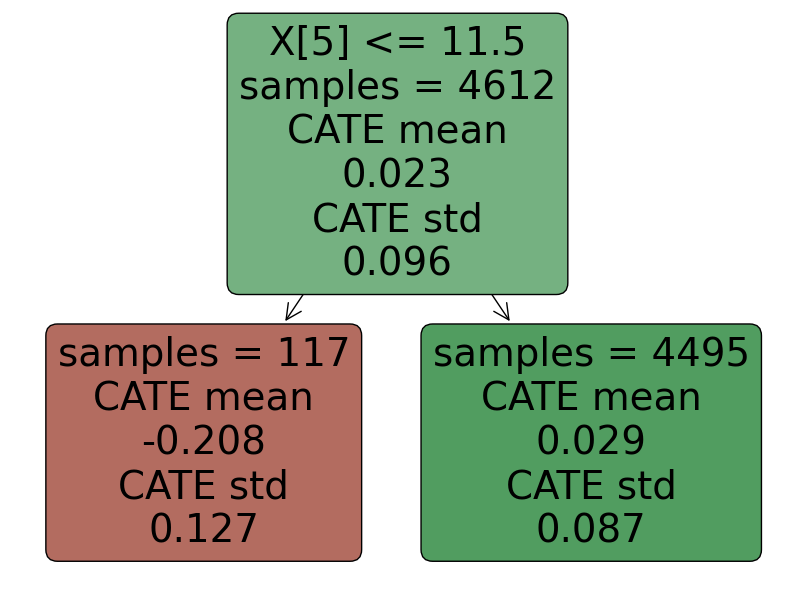

In [35]:
from econml.cate_interpreter import SingleTreeCateInterpreter

intrp = SingleTreeCateInterpreter(max_depth=1)
intrp.interpret(T_learner,X_test)
intrp.plot()

Este árbol de decisión indica cómo la característica x[5] influye en el efecto promedio del tratamiento condicional. La división sugiere que el efecto del tratamiento varía significativamente según el valor de x[5]. Esto podría ser útil para entender la heterogeneidad en los efectos del tratamiento y para tomar decisiones más específicas basadas en la característica x[5].

El árbol de decisión comienza con 4612 muestras y se divide según si la característica x[5] es menor o igual a 11.5.

Para las muestras donde x[5] es menor o igual a 11.5, el efecto del tratamiento (CATE) es en promedio negativo (-0.208).

Para las muestras donde x[5] es mayor a 11.5, el efecto del tratamiento (CATE) es en promedio positivo (0.029).

x[5] corresponde a la variable loan_amount_000s, que guarda la información de la cantidad del préstamo en miles de doláres.

#### Interprete de políticas

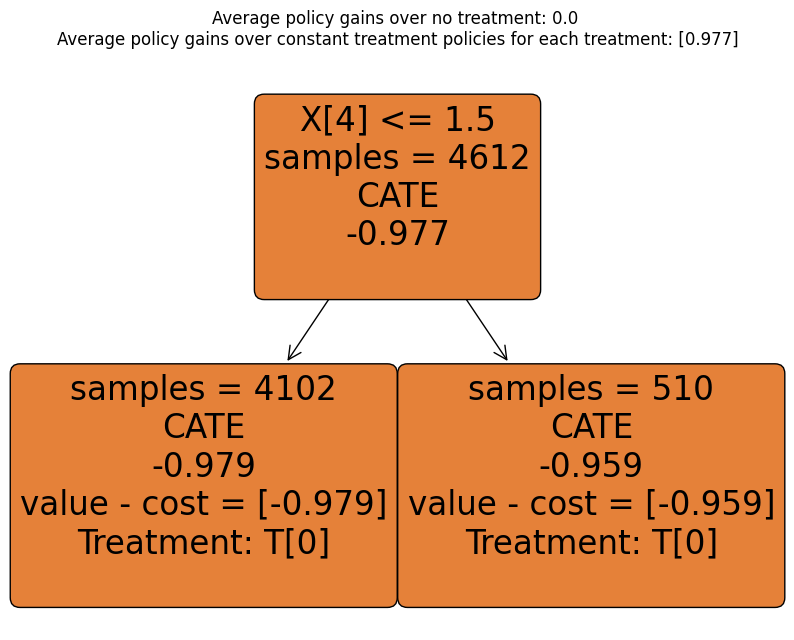

In [36]:
from econml.cate_interpreter import SingleTreePolicyInterpreter
# Tree policy
# Hacer tree-based policy recommendations from CATE model
intrp = SingleTreePolicyInterpreter(max_depth=1)
intrp.interpret(T_learner, X_test, sample_treatment_costs=1) 
intrp.plot()
# modificando el coste de la intervención se modifica la regla de decisión para aplicar tratamiento

Este árbol de decisión sugiere que el tratamiento tiene un efecto negativo en ambos subconjuntos definidos por x[4] que corresponde a la variable owner_occupancy, pero el efecto es más negativo cuando x[4] es menor o igual a 1.5. Esto podría ser útil para decidir cuándo no aplicar el tratamiento basado en la característica x[4].

Para las muestras donde x[4] es menor o igual a 1.5, el efecto del tratamiento (CATE) es en promedio más negativo (-0.979). Es decir, el promedio es más negativo cuando el inmueble está ocupada por el dueño como vivienda principal.


Para las muestras donde x[4] es mayor a 1.5, el efecto del tratamiento (CATE) es en promedio menos negativo (-0.959).

En ambos nodos hijos, el tratamiento recomendado es T[0], probablemente indicando que no se debe aplicar el tratamiento en estas condiciones dado el efecto negativo observado.

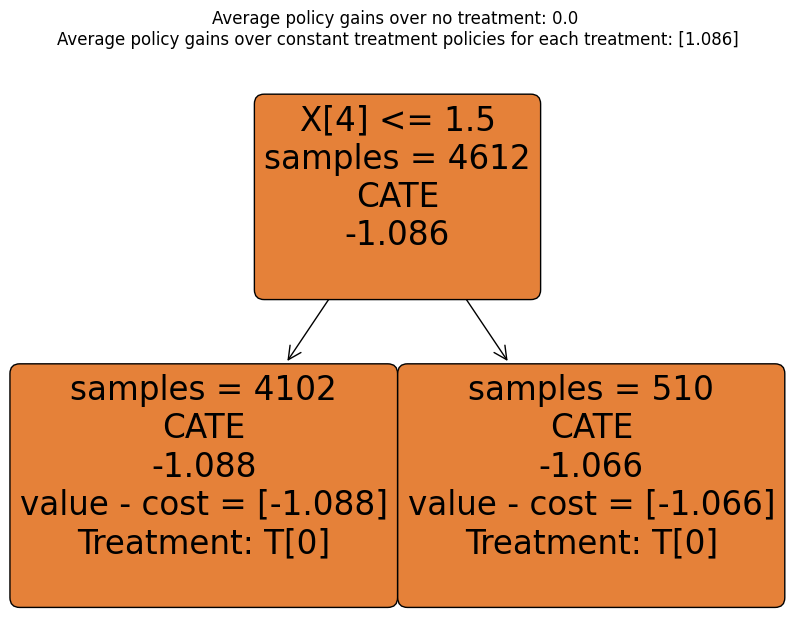

In [37]:
# policy tree pesimista: se trata a un menor número de unidades
intrp = SingleTreePolicyInterpreter(max_depth=1, risk_level=0.05,risk_seeking=False)
intrp.interpret(T_learner, X_test, sample_treatment_costs=1) 
intrp.plot()

Este árbol de decisión sugiere que el tratamiento tiene un efecto negativo en ambos subconjuntos definidos por x[4] que corresponde a la variable owner_occupancy, pero el efecto es más negativo cuando x[4] es menor o igual a 1.5. Esto podría ser útil para decidir cuándo no aplicar el tratamiento basado en la característica x[4].

Para las muestras donde x[4] es menor o igual a 1.5, el efecto del tratamiento (CATE) es en promedio más negativo (-1.088). Es decir, el promedio es más negativo cuando el inmueble está ocupada por el dueño como vivienda principal.

Para las muestras donde x[4] es mayor a 1.5, el efecto del tratamiento (CATE) es en promedio menos negativo (-1.066).

En ambos nodos hijos, el tratamiento recomendado es T[0], probablemente indicando que no se debe aplicar el tratamiento en estas condiciones dado el efecto negativo observado.

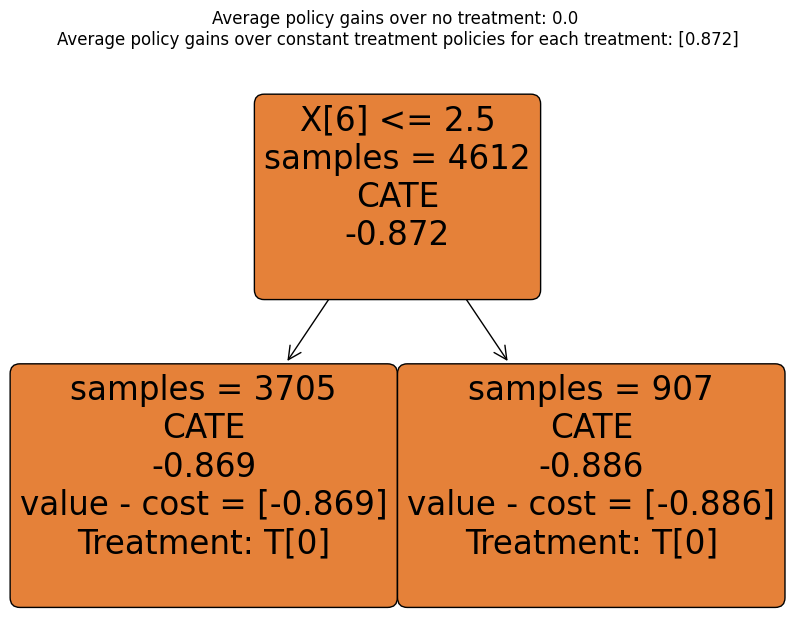

In [38]:
# policy tree optimista: se trata a un mayor número de unidades
intrp = SingleTreePolicyInterpreter(max_depth=1, risk_level=0.05,risk_seeking=True)
intrp.interpret(T_learner, X_test, sample_treatment_costs=1) 
intrp.plot()

Este árbol de decisión sugiere que el tratamiento tiene un efecto negativo en ambos subconjuntos definidos por x[6] que corresponde a la variable applicant_ethnicity, pero el efecto es más negativo cuando x[6] es menor o igual a 2.5. Esto podría ser útil para decidir cuándo no aplicar el tratamiento basado en la característica x[6].

Para las muestras donde x[6] es menor o igual a 2.5, el efecto del tratamiento (CATE) es en promedio menos negativo (-0.869). Es decir, el promedio es menos negativo cuando la información de la raza del aplicante es conocida.

Para las muestras donde x[6] es mayor a 2.5, el efecto del tratamiento (CATE) es en promedio más negativo (-0.886).

En ambos nodos hijos, el tratamiento recomendado es T[0], probablemente indicando que no se debe aplicar el tratamiento en estas condiciones dado el efecto negativo observado.

#### Interpretabilidad: Shapley Values

In [39]:
import shap
shap_values = T_learner.shap_values(X_test)

print(shap_values)


PermutationExplainer explainer: 4613it [15:43,  4.85it/s]                          

{'denied': {'refinancing_1': .values =
array([[ 1.94305738e-02,  1.69281734e-03, -1.43781885e-02, ...,
        -1.98172773e-02,  1.01138675e-03,  4.65677182e-03],
       [-3.10126801e-02,  3.20322044e-03,  6.41563821e-04, ...,
        -5.38099849e-03, -1.61925460e-04,  2.19235527e-02],
       [-5.19690130e-02,  5.65997336e-03,  7.31712065e-05, ...,
         2.60606651e-03, -1.90369075e-03, -6.33628408e-03],
       ...,
       [-1.10903025e-02, -5.13281966e-03, -2.34478329e-03, ...,
        -1.92252594e-03, -1.16626055e-04, -2.45378177e-02],
       [ 3.22945604e-02,  3.59401441e-03,  7.72275686e-03, ...,
        -6.28014262e-03, -1.26198340e-03, -2.96625643e-02],
       [-2.62151345e-02,  6.25861337e-04, -1.91767094e-03, ...,
         1.30027223e-02, -4.42717713e-04, -9.20680118e-03]])

.base_values =
array([0.02413531, 0.02413531, 0.02413531, ..., 0.02413531, 0.02413531,
       0.02413531])

.data =
array([[1.15712000e+05, 9.00000000e+00, 1.00000000e+00, ...,
        1.84425442e-01, 1.

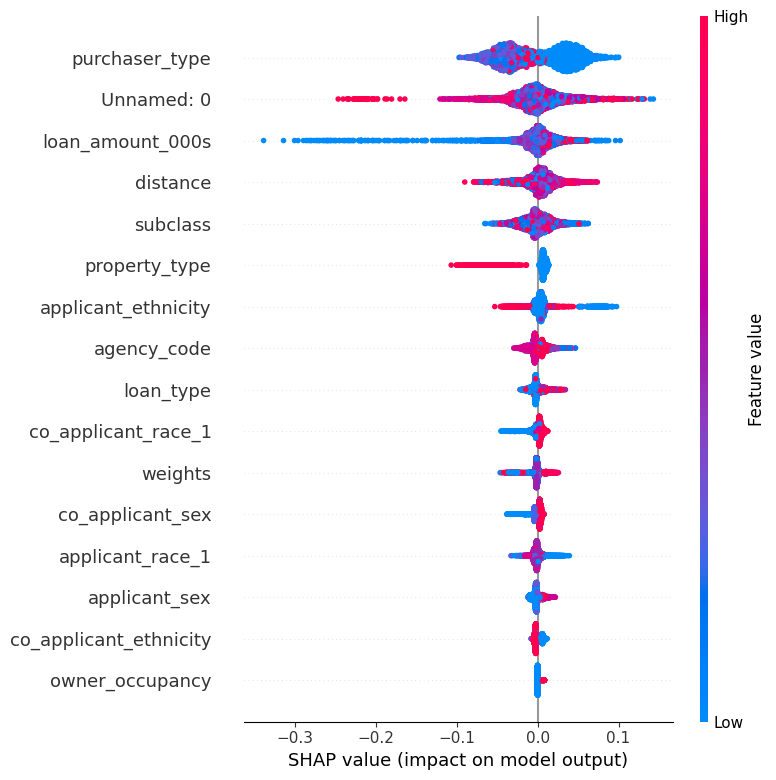

In [40]:
# effect heterogeneity feature importances with summary plot
shap.summary_plot(shap_values['denied']['refinancing_1'])

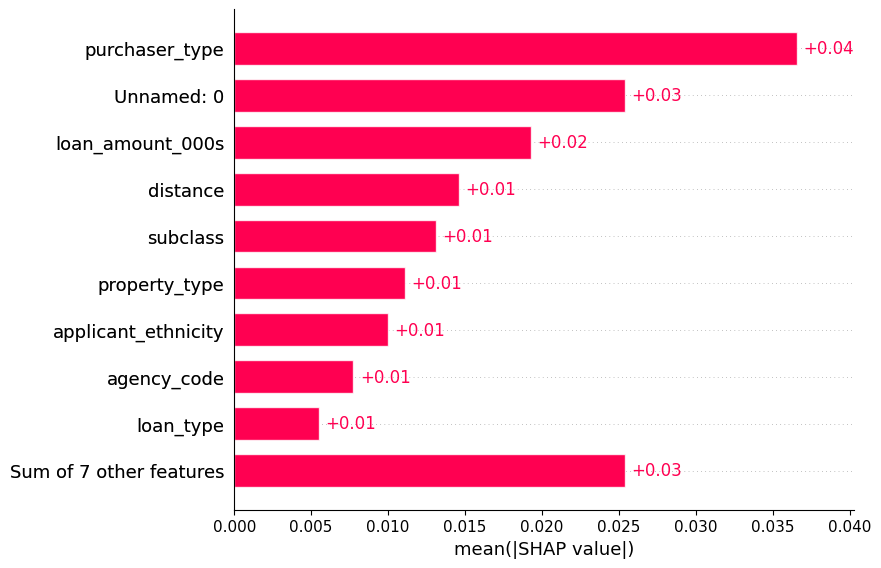

In [41]:
shap.plots.bar(shap_values['denied']['refinancing_1'])

Este gráfico de resumen de valores SHAP proporciona una visión clara de cuáles características son más influyentes en el modelo y cómo sus valores afectan las predicciones.

Teniendo en cuenta la información que aportan los gráficos anteriores, se puede apreciar como los valores SHAP muestran que ciertas características, especialmente purchaser_type, loan_amount_000s, distance, y subclass, son determinantes clave en las decisiones de rechazo de hipotecas.

### S learner

In [42]:
# Estimamos  modelo lineal con interacciones; haremos regularización LASSO
 
poly = PolynomialFeatures(degree=4, include_bias=False)
linregLASSO =  Lasso(alpha=0.1)
overall_model = make_pipeline(poly,linregLASSO) 

# Instanciamos el S learner
S_learner = SLearner(overall_model=overall_model)
# Entrenamos S_learner (incluimos la opcion inference=bootstrap para obtener errores estándar)
S_learner.fit(Y_train, T_train, X=X_train, inference="bootstrap")
# Estimamos efectos tratamiento sobre datos de prueba
S_te = S_learner.effect(X_test)

# Histograma de TEs
plt.hist(S_te)


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.258e+02, tolerance: 2.277e-01


In [ ]:
# Podemos asimismo obtener intervalos
# TE e intervalo para todos los 
lb,ub = S_learner.effect_interval(X_test)

In [ ]:
# Intervalo para ATE
S_learner.ate_interval(X_test,T0=0,T1=1)

Tras diferentes pruebas variando los parámetros no se ha encontrado una versión del S-learner que converja a los datos del problema. 

El S-learner puede enfrentar mayores desafíos de convergencia debido a la complejidad adicional de modelar conjuntamente las características y las interacciones del tratamiento en un solo modelo. En cambio, el T-learner al dividir la tarea en dos modelos más simples, puede manejar mejor la modelización y la convergencia.

### X Learner

(array([   5.,   27.,   86.,  352., 1669., 1050.,  750.,  463.,  180.,
          30.]),
 array([-0.23169083, -0.18386762, -0.13604442, -0.08822122, -0.04039801,
         0.00742519,  0.05524839,  0.1030716 ,  0.1508948 ,  0.198718  ,
         0.2465412 ]),
 <BarContainer object of 10 artists>)

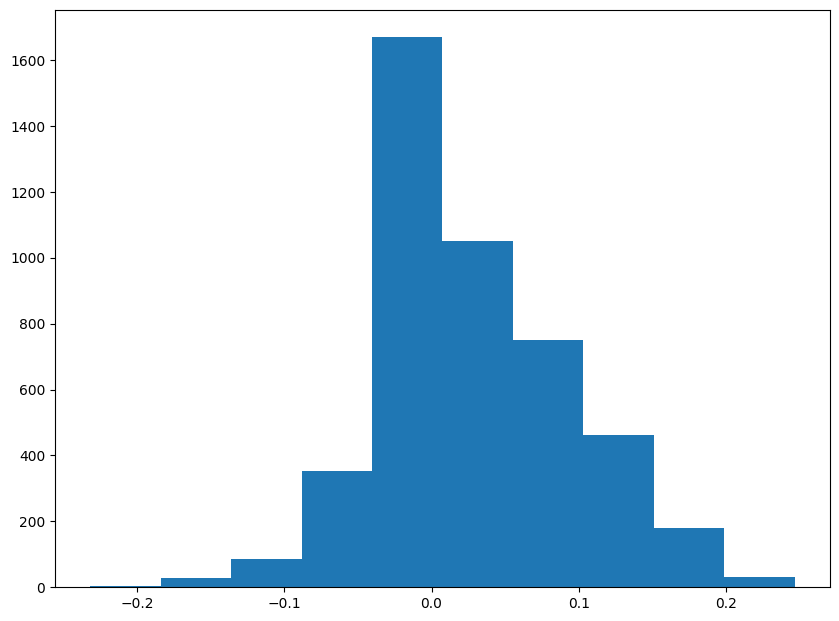

In [ ]:
n = data.shape[0]
models = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
X_learner = XLearner(models=models)

# Entrenamiento del T_learner (con la opción inference para poder realizar inferencia sobre resultados)
X_learner.fit(Y_train, T_train, X=X_train,inference="bootstrap") # generamos intervalos con remuestreo bootstrap

# Una vez ajustado el modelo estimamos los effectos (en este caso sobre el conjunto de prueba) 
X_te = X_learner.effect(X_test) # efectos heterogeneos

# Visualización del efecto tratamiento en el conjunto test
plt.hist(X_te)

El histograma muestra la distribución de los efectos estimados del tratamiento para las observaciones en el conjunto de prueba. Observaciones clave del histograma:

    Distribución Centrada en Cero: La mayoría de los efectos estimados del tratamiento se agrupan alrededor de 0. Esto sugiere que el tratamiento, en promedio, no tiene un efecto significativo en la mayoría de las observaciones.
    
    Sesgo a la Derecha: Hay una cola a la derecha del histograma, indicando que hay algunas observaciones donde el tratamiento tiene un efecto positivo significativo.

In [ ]:
# Podemos asimismo obtener intervalos
# TE e intervalo para todos los 
X_learner.effect_interval(X_test)

(array([-0.16822958,  0.01444229, -0.13894321, ..., -0.0841237 ,
        -0.09341119, -0.05832985]),
 array([0.07741607, 0.13122431, 0.15771666, ..., 0.00746115, 0.08038721,
        0.03056235]))

In [ ]:
# Intervalo para ATE
X_learner.ate_interval(X_test,T0=0,T1=1)

(-0.06624234106240037, 0.1208819865988588)

Para el caso del intervalo del ATE observamos que este intervalo también incluye 0, lo que indica que el efecto promedio del tratamiento no es significativamente diferente de 0. Esto sugiere que, en general, el tratamiento no tiene un impacto significativo en la población de prueba.

## Conclusión

La falta de un efecto significativo promedio sugiere que el tratamiento evaluado no logra producir un cambio notable en la mayoría de los casos. Esto puede ser una indicación de que el tratamiento no es efectivo en términos generales o que su efecto varía significativamente entre diferentes subgrupos de la población.

La existencia de una cola a la derecha en la distribución indica que hay subgrupos dentro de la población que sí responden positivamente al tratamiento. Este hallazgo puede ser crucial para identificar segmentos específicos donde el tratamiento podría ser beneficioso.

Análisis de Subgrupos: Dado que algunos subgrupos muestran una respuesta positiva significativa, se recomienda realizar un análisis más detallado para identificar características específicas de estos subgrupos. Esto podría ayudar a ajustar el tratamiento para maximizar su efectividad en poblaciones específicas.

Revisión del Tratamiento: Considerar posibles modificaciones o combinaciones del tratamiento que podrían tener un efecto más robusto en la población general, dado que el efecto promedio actual es insignificante.

Investigación Adicional: Realizar estudios adicionales para explorar otros factores que puedan estar influyendo en la efectividad del tratamiento, como variaciones en la implementación o características individuales de los sujetos.

En conclusión, mientras que el tratamiento no muestra un impacto significativo a nivel global, hay indicios de que podría ser efectivo en subgrupos específicos. Un análisis más profundo y una posible reestructuración del enfoque del tratamiento podrían ser necesarios para mejorar su efectividad general. 